<a href="https://colab.research.google.com/github/eggtgg/bt_minhtriho_all/blob/main/computer_vision/cnn_20.12.23/nhom5_hand_draw_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split

In [ ]:
!gdown 1cIchMr_pfQjQr9xiofq0g_T847lX5CtM
!unzip "/content/all_user.zip" -d "/content/data/"

Downloading...
From: https://drive.google.com/uc?id=1cIchMr_pfQjQr9xiofq0g_T847lX5CtM
To: /content/all_user.zip
100% 20.6M/20.6M [00:00<00:00, 28.6MB/s]


In [ ]:
data_transform = transforms.Compose([
    transforms.Resize((70, 70)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(root='/content/data/all_user/images', transform=data_transform)

# Splitting the dataset into train and test sets
train_size = int(0.7 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

# Creating separate data loaders for train and test sets
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # 1 input channel (grayscale), 32 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)  # 32 input channels, 64 output channels, 3x3 kernel
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer with 2x2 kernel and stride 2
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Fully connected layer, input size is calculated after pooling
        self.fc2 = nn.Linear(128, 4)  # Output layer with 4 classes (assuming 4 categories: hình tròn, hình vuông, hình tam giác, khác)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)  # Flatten the tensor for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
model = CNN()

In [ ]:
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer (Adam)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f"Epoch [{epoch + 1}/{num_epochs}], "
                  f"Step [{i + 1}/{len(trainloader)}], "
                  f"Loss: {running_loss / 100:.4f}")
            running_loss = 0.0

print("Finished Training")

Epoch [1/1], Step [100/1676], Loss: 0.0230
Epoch [1/1], Step [200/1676], Loss: 0.0001
Epoch [1/1], Step [300/1676], Loss: 0.0177
Epoch [1/1], Step [400/1676], Loss: 0.0010
Epoch [1/1], Step [500/1676], Loss: 0.0049
Epoch [1/1], Step [600/1676], Loss: 0.0052
Epoch [1/1], Step [700/1676], Loss: 0.0000
Epoch [1/1], Step [800/1676], Loss: 0.0003
Epoch [1/1], Step [900/1676], Loss: 0.0040
Epoch [1/1], Step [1000/1676], Loss: 0.0141
Epoch [1/1], Step [1100/1676], Loss: 0.0059
Epoch [1/1], Step [1200/1676], Loss: 0.0319
Epoch [1/1], Step [1300/1676], Loss: 0.0073
Epoch [1/1], Step [1400/1676], Loss: 0.0101
Epoch [1/1], Step [1500/1676], Loss: 0.0435
Epoch [1/1], Step [1600/1676], Loss: 0.0329
Finished Training


In [ ]:
# Evaluate on test set
correct = 0
total = 0
model.eval()
all_preds_test = []
all_labels_test = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds_test.extend(predicted.numpy())
        all_labels_test.extend(labels.numpy())

accuracy_test = correct / total
print(f'Accuracy of the network on the test images: {100 * accuracy_test:.2f}%')

Accuracy of the network on the test images: 98.85%


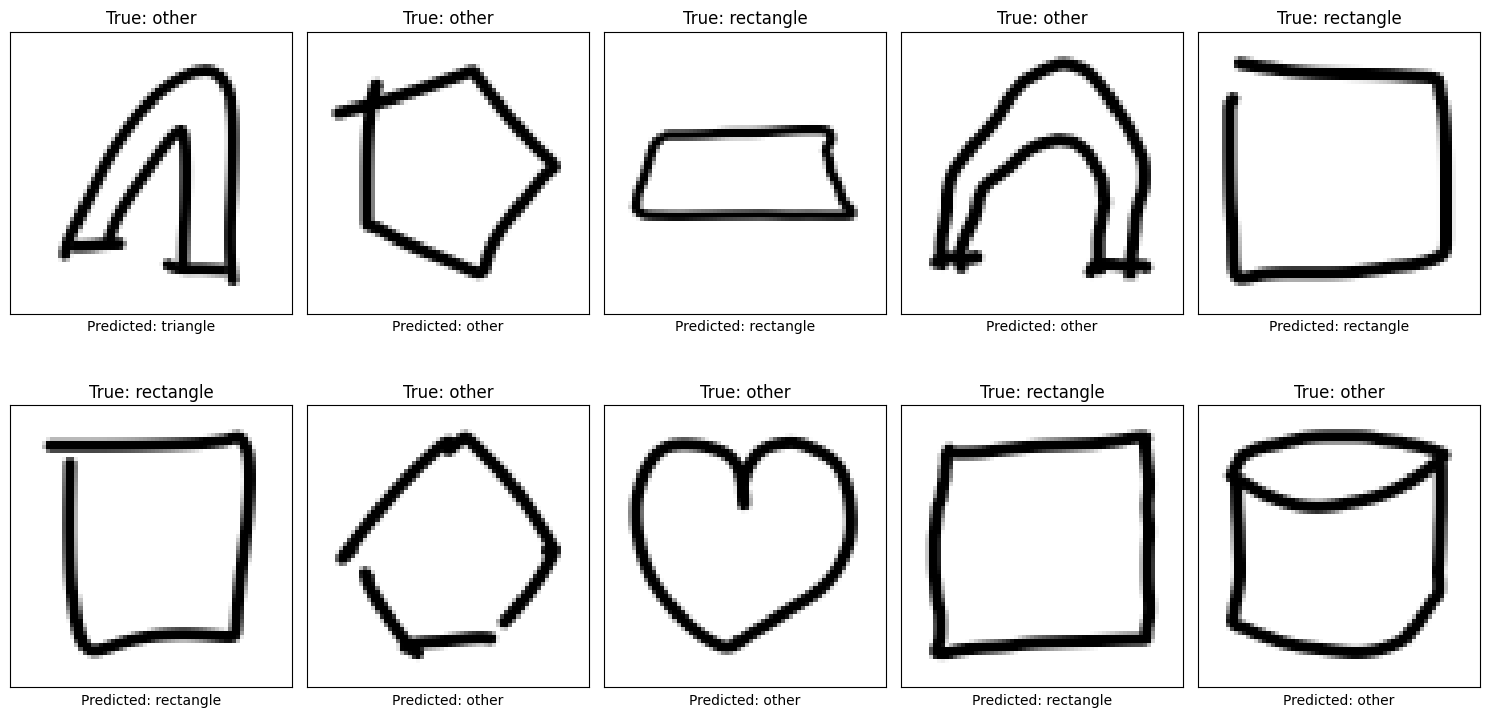

In [ ]:
import random

class_names = ['ellipse', 'other', 'rectangle', 'triangle']

# Retrieve 10 random images from the test set
images_to_display = []
labels_to_display = []

for i in range(10):
    index = random.randint(0, len(test_dataset) - 1)
    input_image, label = test_dataset[index]
    images_to_display.append(input_image)
    labels_to_display.append(label)

# Displaying the images along with predictions
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images_to_display[i].permute(1, 2, 0), cmap='gray')  # Convert tensor to numpy array for display
    plt.title(f"True: {class_names[labels_to_display[i]]}")

    # Predict on each image
    input_image = images_to_display[i].unsqueeze(0)
    predicted_output = model(input_image)
    _, predicted_label = torch.max(predicted_output, 1)
    plt.xlabel(f"Predicted: {class_names[predicted_label]}")
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks

plt.tight_layout()
plt.show()

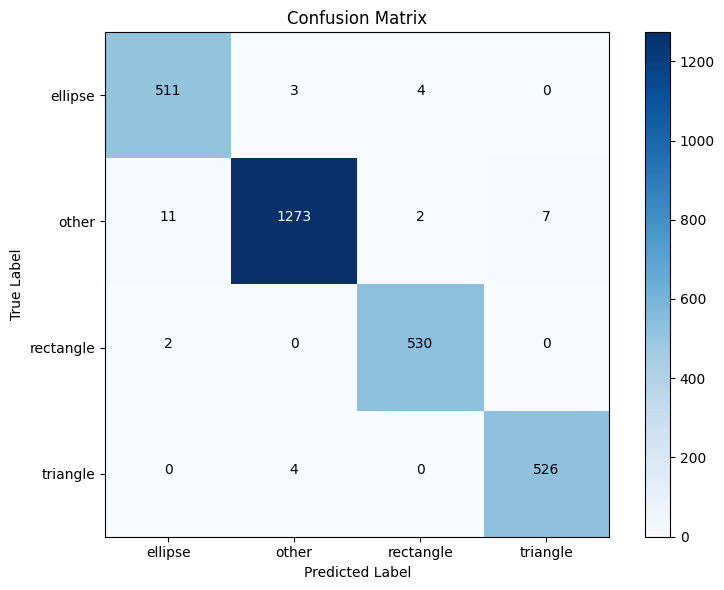

In [ ]:
# Display the confusion matrix
cm = confusion_matrix(all_labels_test, all_preds_test)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['ellipse', 'other', 'rectangle', 'triangle']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Đoạn code xử lý dự đoán từ URL ảnh
def predict_from_url(image_url, model):
    # Tải ảnh từ URL
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))

    # Áp dụng các biến đổi tương tự như đã áp dụng cho tập dữ liệu huấn luyện
    data_transform = transforms.Compose([
        transforms.Resize((70, 70)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ])

    # Áp dụng biến đổi cho ảnh và chuẩn bị để dự đoán
    input_image = data_transform(image).unsqueeze(0)  # Thêm chiều batch

    # Dự đoán từ ảnh đã tải về
    predicted_output = model(input_image)
    _, predicted_label = torch.max(predicted_output, 1)

    class_names = ['ellipse', 'other', 'rectangle', 'triangle']

    # Hiển thị hình ảnh và dự đoán
    plt.imshow(image)
    plt.title(f"Predicted: {class_names[predicted_label]}")
    plt.axis('off')  # Ẩn trục
    plt.show()

In [ ]:
# Sử dụng hàm predict_from_url
image_url = "https://raw.githubusercontent.com/thinh2904/Excel/main/tamgiac.png"
predict_from_url(image_url, model)

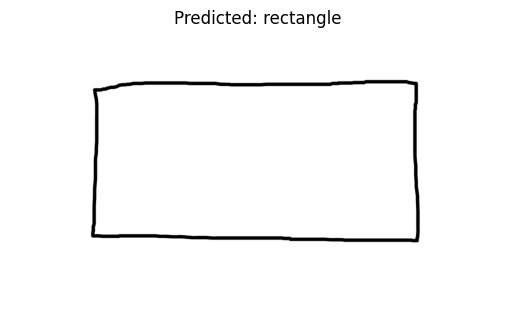

In [ ]:
image_url = "https://raw.githubusercontent.com/thinh2904/Excel/main/hcn.png"
predict_from_url(image_url, model)

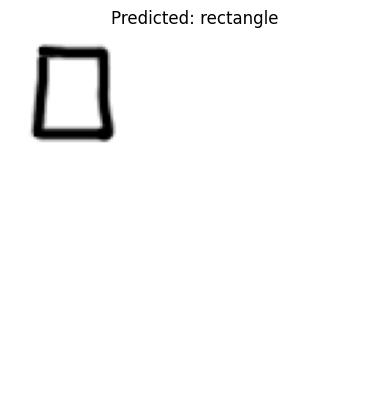

In [ ]:
image_url = 'https://raw.githubusercontent.com/eggtgg/bt_minhtriho_all/main/computer_vision/cnn_20.12.23/vuong_1.png'
predict_from_url(image_url, model)

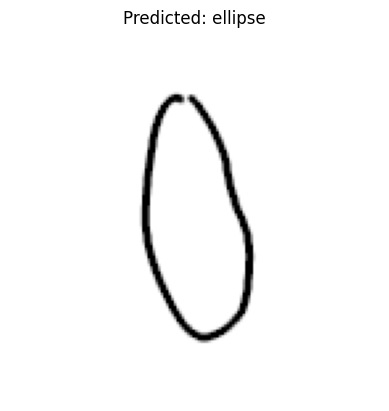

In [ ]:
image_url = 'https://raw.githubusercontent.com/eggtgg/bt_minhtriho_all/main/computer_vision/cnn_20.12.23/elise_1.png'
predict_from_url(image_url, model)

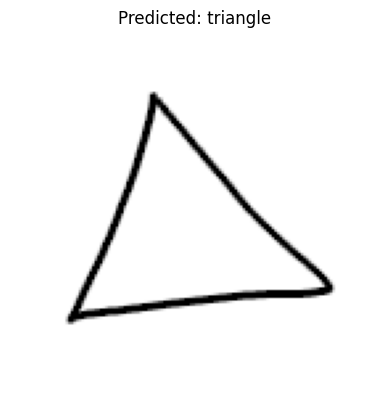

In [ ]:
image_url = 'https://raw.githubusercontent.com/eggtgg/bt_minhtriho_all/main/computer_vision/cnn_20.12.23/tamgiac_2.png'
predict_from_url(image_url, model)

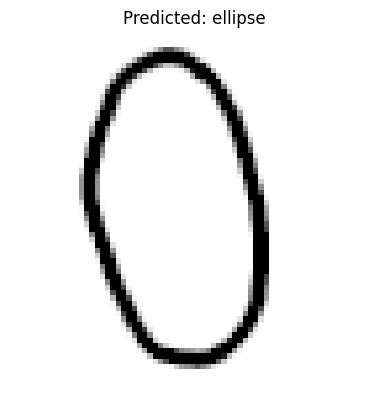

In [ ]:
image_url = 'https://raw.githubusercontent.com/eggtgg/bt_minhtriho_all/main/computer_vision/cnn_20.12.23/elise_2.png.png'
predict_from_url(image_url, model)

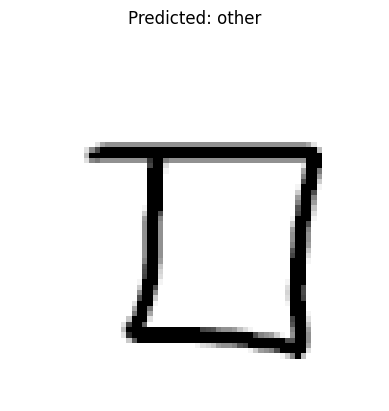

In [ ]:
image_url = 'https://raw.githubusercontent.com/eggtgg/bt_minhtriho_all/main/computer_vision/cnn_20.12.23/vuong_3.png'
predict_from_url(image_url, model)

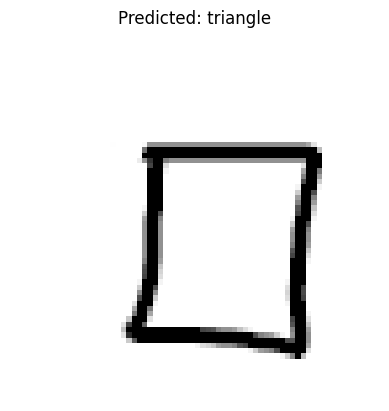

In [ ]:
image_url = 'https://raw.githubusercontent.com/eggtgg/bt_minhtriho_all/main/computer_vision/cnn_20.12.23/vuong_v.png'
predict_from_url(image_url, model)

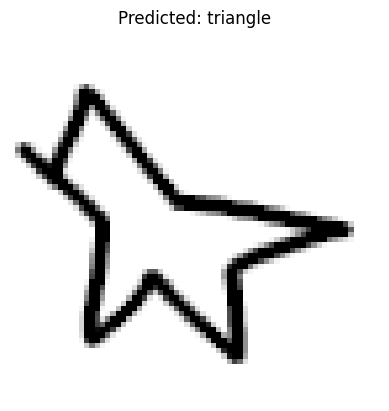

In [ ]:
image_url = 'https://raw.githubusercontent.com/eggtgg/bt_minhtriho_all/main/computer_vision/cnn_20.12.23/other_1.png'
predict_from_url(image_url, model)

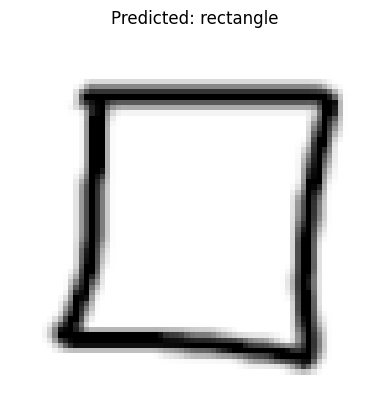

In [ ]:
image_url = 'https://raw.githubusercontent.com/eggtgg/bt_minhtriho_all/main/computer_vision/cnn_20.12.23/vuong_7.png'
predict_from_url(image_url, model)

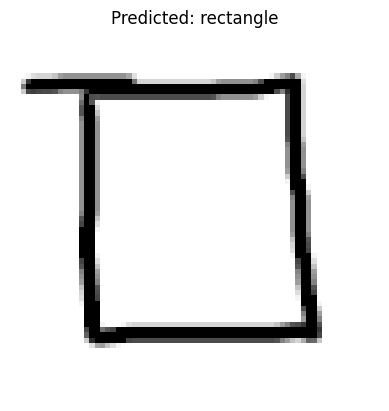

In [ ]:
image_url = 'https://raw.githubusercontent.com/eggtgg/bt_minhtriho_all/main/computer_vision/cnn_20.12.23/vuong_6.png'
predict_from_url(image_url, model)